In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colormaps
from scipy.signal import find_peaks, convolve, medfilt, savgol_filter
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d
import matplotlib.animation as animation
import matplotlib as mpl
from glob import glob
from copy import copy
from natsort import natsorted
from pandas import DataFrame
import sys
import pickle
import pandas as pd
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '../..'))
sys.path.insert(0, parent_dir)
import matplotlibcolors
plt.style.use(parent_dir + '/matplotlibrc')
from KID_S21 import loop_over_S21_files


%matplotlib widget

In [2]:
with open('LT402chip1_master.pkl', 'rb') as f:
    master = pickle.load(f)

In [3]:
dir = r'Z:\KIDonSun\experiments\Entropy ADR/'
chips = ['LT402chip1_BF_20251031', 'LT402chip1_BF_20251120_nibbled', 'LT402chip1_BF_20251203_withLenses']
paths = []
for chip in chips:
    paths.append(dir + chip + '/S21/Power/')
paths
    

['Z:\\KIDonSun\\experiments\\Entropy ADR/LT402chip1_BF_20251031/S21/Power/',
 'Z:\\KIDonSun\\experiments\\Entropy ADR/LT402chip1_BF_20251120_nibbled/S21/Power/',
 'Z:\\KIDonSun\\experiments\\Entropy ADR/LT402chip1_BF_20251203_withLenses/S21/Power/']

In [5]:
# for i, path in enumerate(paths):
#     df = loop_over_S21_files(path, kid=None, pread=110, plot=False, model='khalilswensonbias', method='least_squares')
#     with open(chips[i] + '_Qs.pkl', 'wb') as f:
#         pickle.dump(df, f)


In [4]:
dfs = []
for chip in chips:
    with open(chip + '_Qs.pkl', 'rb') as f:
        df = pickle.load(f) 
        dfs.append(df)

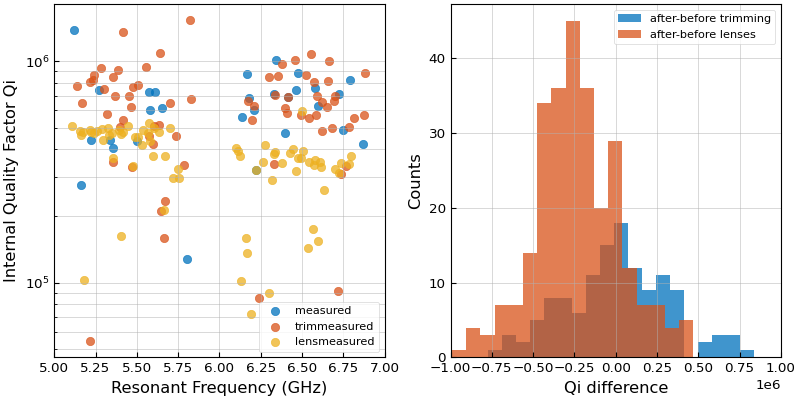

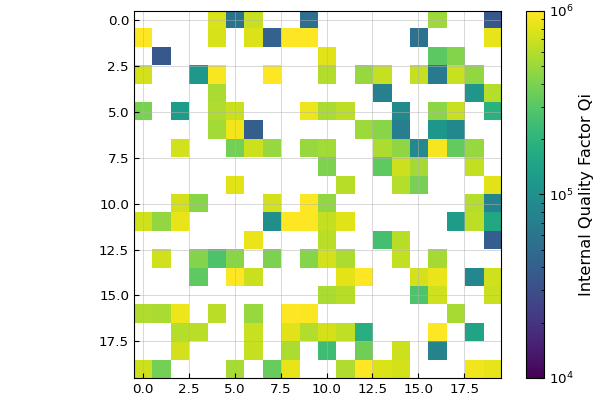

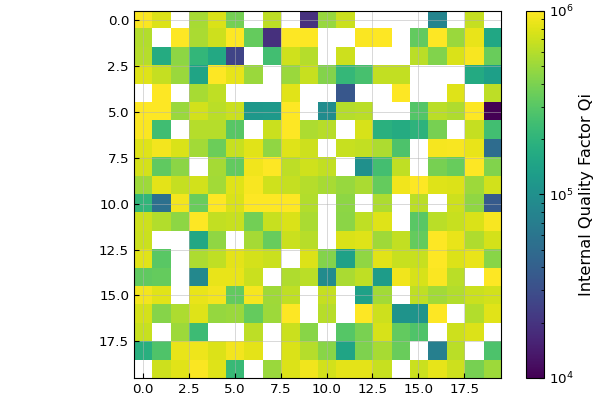

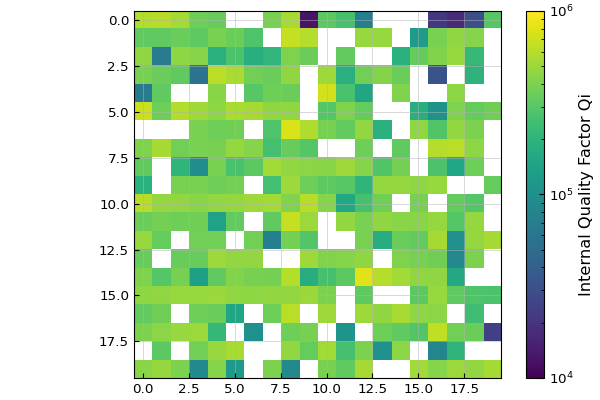

In [5]:
min_df = 0.002
labels = ['measured', 'trimmeasured', 'lensmeasured']
map = np.ones((20,20), dtype=int)
map[master['design']['row'].astype(int), master['design']['col'].astype(int)] = np.arange(400)
fig, axes = plt.subplot_mosaic('ab', figsize=(8, 4), constrained_layout=True)
for i, df in enumerate(dfs):
    fig2, ax = plt.subplots(figsize=(6, 4), constrained_layout=True)
    label = labels[i]
    f0_map = master[label]['f0']
    f0 = df['f0']
    Ql = df['Ql']
    Qi = df['Qi']
    Qc = df['Qc']
    a = df['a_nonlin']

    df0s = np.asarray(f0)[1:] - np.asarray(f0)[:-1]
    too_close = df0s < min_df
    too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))
    Qi_mask = (Qi > 0) & (Qi < 1e7)
    Qc_mask = (Qc > 0) & (Qc < 1e6)
    nonlin_mask = (a >= 0) & (a < 0.7)
    mask = Qi_mask & Qc_mask & nonlin_mask & ~too_close_mask
    df_filtered = df[mask]

    f0_fit = df_filtered['f0']
    ids = []
    for f0 in f0_fit:
        id = np.nanargmin(np.abs(f0_map - f0))
        ids.append(id)

    keys = ['Ql', 'Qc', 'Qi', 'a_nonlin']
    for key in keys:
        master[label]['Qi'] = np.empty(f0_map.shape)
        master[label]['Qi'][:] = np.nan
        master[label]['Qi'][ids] = df_filtered['Qi']
        
    df0s = f0_map[1:] - f0_map[:-1]
    too_close = df0s < min_df
    too_close_mask = np.hstack((False, too_close)) + np.hstack((too_close, False))
    Qi_map = master[label]['Qi']
    axes['a'].scatter(f0_map[~too_close_mask], Qi_map[~too_close_mask], label=label, alpha=0.75)
    if i == 1 or i==2:
        axes['b'].hist((master[label]['Qi']-master[labels[i-1]]['Qi']), bins=50, alpha=0.75)
    im = ax.imshow(master[label]['Qi'][map], norm=mpl.colors.LogNorm(vmin=1e4, vmax=1e6), cmap='viridis')
    cbar = fig2.colorbar(im, ax=ax)
    cbar.set_label('Internal Quality Factor Qi')
ax = axes['a']
ax.set_yscale('log')
ax.set_xlabel('Resonant Frequency (GHz)')
ax.set_ylabel('Internal Quality Factor Qi')
ax.set_xlim(5, 7)
ax.legend()
ax = axes['b']
# ax.set_xscale('log')
ax.set_xlabel('Qi difference')
ax.set_ylabel('Counts')
ax.set_xlim(-10e5, 10e5)
ax.legend(['after-before trimming', 'after-before lenses'])